#### Some useful terms
* **tokenization**: segmenting text into linguistic units such as words, punctuation, numbers, alpha-numerics, etc. 
* **stop words**: typically, these are function words. Functions words have very little substantive meaning and primarily denote grammatical relationships between content words, such as prepositions (in, out, under), pronouns (I, you, he, who), conjunctions (and, but, till, as) and in/definite articles (a, an, the) 
* **stemming**: the process of reducing inflected (or sometimes derived) words to their word stem, base or root form. Operates on a single word without knowledge of the context
* **lemmatization**: like stemming, but operates within the larger context surrounding the word, such as neighboring sentences or even an entire document.
* **stemming vs lemmatization**: The word "meeting" can be either the base form of a noun or a form of a verb ("to meet") depending on the context; e.g., "in our last meeting" or "We are meeting again tomorrow". Unlike stemming, lemmatisation attempts to select the correct lemma depending on the context.
* **dependency parser**: analyzes the grammatical structure of a sentence, establishing relationships between "head" words and words which modify those heads. For example, in the following sentence: 'This time around, they're moving even faster', an arrow from the word moving to the word faster indicates that faster modifies moving, and the label 'advmod' assigned to the arrow describes the exact nature of the dependency.

In [1]:
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import spacy
from spacy import displacy
from nltk.tokenize import TweetTokenizer
import pandas as pd
import re
pd.set_option('max_colwidth', 80)
from re import sub, split
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, MDS
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#### For the uninitiated
* truncated SVD works on term count/tf-idf matrices as returned by the vectorizers:
    * CountVectorizer and TfidfVectorizer (both sklearn) 
    * these convert a collection of text documents to a matrix of token counts
* 50 refers to the dimensionality of the output data. I think these are the linear combination of terms that explain most of the variance of terms across tweets 
* TSNE takes a high dimensional data set and reduces it to a low dimensional graph that attempts to retain a lot of the information

In [2]:
def plot_embedding(V, y):
    """ Visualizes a vocabulary embedding via TSNE """
    V = TruncatedSVD(50).fit_transform(V)
    d = TSNE(metric='cosine').fit_transform(V)
    d = pd.DataFrame(d).assign(label = y.reset_index(drop=True))
    return sns.scatterplot(x = 0, y = 1, hue = 'label', data = d), d

In [3]:
X = pd.read_csv('data/tweets.csv').tweet
y = pd.read_csv('data/tweets.csv').label
X.head(10)

0    RT @LilMissRightie: Here's CNN on Sharia law. You can be stoned or have your...
1    RT @NetworksManager: LOOK obama Clinton cronies ILLEGALLY arm &amp; train mu...
2    RT @GrrrGraphics: #ThrowbackThursday #BenGarrison #cartoon from 2013 #Obama ...
3    RT @PeterTownsend7: Say 'Islam is peace', or else!  #trump #maga #isis #tcot...
4    RT @ToddDracula: @realDonaldTrump All aboard the Trump Train! #ChooChoo 🚂 ht...
5    RT @JudicialWatch: FLASHBACK &gt;&gt; Judicial Watch Releases Huma Abedin De...
6    RT @LouDobbs: Following FBI presser, @realDonaldTrump says “the system is ri...
7    RT @Ricky_Vaughn99: Trump: "We're Running Against a Rigged Press" https://t....
8    RT @mitchellvii: Literally 98% of Hillary supporters I see online are astrot...
9    RT @ClarkW2016: @ConstantinCI @CathyTo47590555 \nIslam. ... https://t.co/8Fw...
Name: tweet, dtype: object

#### Initial data cleaning requirements that appear necessary after looking at the first 10 tweets:
* remove twitter handles
* remove emojis
* remove URLs
* remove RT
* remove random html entities (e.g. &amp; &gt; \n)
* remove #s
* potentially keep only words

In [4]:
def clean_twitter(s):
    """ Cleans Twitter specific issues    
    """
    
    # remove twitter handles (@user); URLs; RT; and random punctuation
    s = re.sub(r"([@#&]\w+)|https\S+|RT|:|;|\n|@", '', s)
    
    # remove emojis (https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python)
    s = s.encode('ascii', 'ignore').decode('ascii')
    
    return s    

In [5]:
def clean_twitter_2(s):
    """ Cleans Twitter specific issues and keep only words     
    """
    
    # remove twitter handles (@user); URLs; RT; and random punctuation
    s = re.sub(r"([@#&]\w+)|https\S+|RT|:|;|\n|@", '', s)
    
    # keep only words
    s = re.sub("[^a-zA-Z]", " ", s)
    
    return s    

In [6]:
# Initialize spacy 'en' model
nlp = spacy.load('en')

def clean_twitter_3(s):
    """ Cleans Twitter specific issues    
    """
    
    # remove twitter handles (@user); URLs; RT; and random punctuation
    s = re.sub(r"([@#&]\w+)|https\S+|RT|:|;|\n|@", '', s)
    
    # keep only words
    s = re.sub("[^a-zA-Z]", " ", s)
    
    # Parse the tweet using the loaded 'en' model object `nlp`
    s = nlp(s)
    
    # Extract the lemma for each token and join
    " ".join([token.lemma_ for token in s])

    return s

    # BONUS: Try using the library "spacy" to 
    # do further processing, such as lemmatizing
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 

In [7]:
clean = X.map(clean_twitter)
clean.head(5)

0      Here's CNN on Sharia law. You can be stoned or have your hands cut off, bu...
1      LOOK obama Clinton cronies ILLEGALLY arm  train muslims terrorist includin...
2                                                       from 2013  gets crowned     
3                                             Say 'Islam is peace', or else!        
4                                                     All aboard the Trump Train!   
Name: tweet, dtype: object

In [8]:
clean_2 = X.map(clean_twitter_2)
clean.head(5)

0      Here's CNN on Sharia law. You can be stoned or have your hands cut off, bu...
1      LOOK obama Clinton cronies ILLEGALLY arm  train muslims terrorist includin...
2                                                       from 2013  gets crowned     
3                                             Say 'Islam is peace', or else!        
4                                                     All aboard the Trump Train!   
Name: tweet, dtype: object

In [9]:
clean_3 = X.map(clean_twitter_3)
clean_3.head(5)

0    (  , Here, s, CNN, on, Sharia, law,  , You, can, be, stoned, or, have, your,...
1    (  , LOOK, obama, Clinton, cronies, ILLEGALLY, arm,  , train, muslims, terro...
2                                         (     , from,       , gets, crowned,     )
3                             (  , Say,  , Islam, is, peace,   , or, else,         )
4                                        (   , All, aboard, the, Trump, Train,     )
Name: tweet, dtype: object

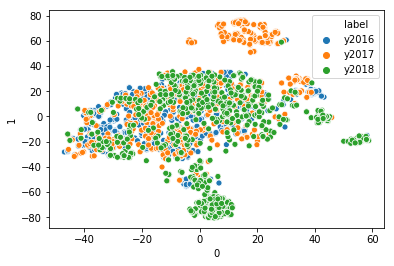

In [10]:
# Let's visualize our data by using nothing but the Sklearn default
# cleaning and tokenizing

vectorizer = CountVectorizer()
V = vectorizer.fit_transform(X)
ax, d = plot_embedding(V, y)

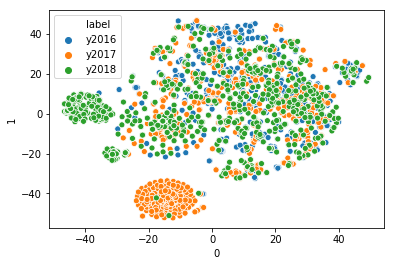

In [11]:
# Now let's see what our cleaning has done

vectorizer = CountVectorizer(preprocessor = clean_twitter)
V = vectorizer.fit_transform(X)
ax, d = plot_embedding(V, y)

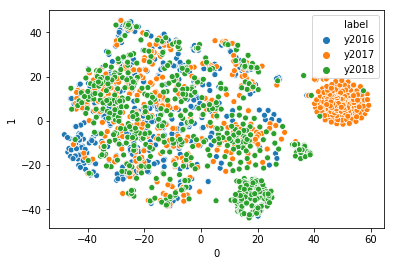

In [12]:
# Now let's see what our cleaning has done

vectorizer = CountVectorizer(preprocessor = clean_twitter_2)
V = vectorizer.fit_transform(X)
ax, d = plot_embedding(V, y)

#### TF-IDF:
* TF = (Number of times term t appears in a document)/(Number of terms in the document)
* IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.
* TF-IDF = TF*IDF

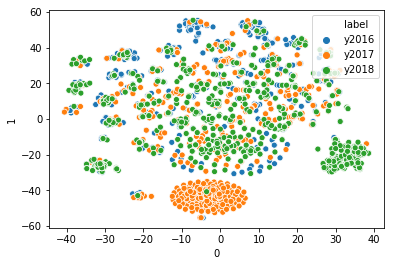

In [13]:
# Now try with TF-IDF vectorizer, and add implicit stopwords!
# Can you get things to separate in the space in a better way? 
# NB: not sure what it means to add implicit stopwords?

from sklearn.feature_extraction import text

my_stop_words = text.ENGLISH_STOP_WORDS.union(["online"])

tfidf_vectorizer = TfidfVectorizer(max_df=0.80, min_df=3, max_features=1000, stop_words=my_stop_words)

# TF-IDF feature matrix
V = tfidf_vectorizer.fit_transform(clean_2)
ax, d = plot_embedding(V, y)